

### Prompts

A common challenge in deep research workflows is that users rarely provide sufficient context in their initial request. 

Requests often lack important details like:

- **Scope and boundaries**: What should be included or excluded?
- **Audience and purpose**: Who is this research for and why?
- **Specific requirements**: Are there particular sources, timeframes, or constraints?
- **Clarification of terms**: What do domain-specific terms or acronyms mean?

Rather than making assumptions, we gather additional context through targeted clarification questions. 

This ensures we understand the user's true intent before investing time in research that might miss the mark.


In [1]:
# ===== IMPORTS =====
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
import json
import operator
from typing_extensions import Optional, Annotated, List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing_extensions import Literal
from langgraph.types import Command
from datetime import datetime
from langchain.chat_models import init_chat_model
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from rich.markdown import Markdown
import os

In [2]:
# ===== GLOBALS / CONFIG =====

#change to ther provider if you want (OpenAI,etc......)

console = Console()
os.environ['GOOGLE_API_KEY'] = "YOUR_API_KEY_HERE"
model = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai", temperature=0)

In [3]:
# ===== UI HELPERS =====
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """
    Display a prompt with rich formatting and XML tag highlighting.
    
    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")  # Highlight headers
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(Panel(
        formatted_text, 
        title=f"[bold green]{title}[/bold green]",
        border_style=border_style,
        padding=(1, 2)
    ))

def format_message_content(message):
    """Convert message content to displayable string"""
    parts = []
    tool_calls_processed = False
    
    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))
    
    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")
    
    return "\n".join(parts)

def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))

            

In [4]:
# ===== PROMPT STRINGS =====
clarify_with_user_instructions = """
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.
If you need to ask a question, follow these guidelines:
- Be concise while gathering all necessary information
- Make sure to gather all the information needed to carry out the research task in a concise, well-structured manner.
- Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and will be rendered correctly if the string output is passed to a markdown renderer.
- Don't ask for unnecessary information, or information that the user has already provided. If you can see that the user has already provided the information, do not ask for it again.

Respond in valid JSON format with these exact keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message that we will start research>"

If you need to ask a clarifying question, return:
"need_clarification": true,
"question": "<your clarifying question>",
"verification": ""

If you do not need to ask a clarifying question, return:
"need_clarification": false,
"question": "",
"verification": "<acknowledgement message that you will now start research based on the provided information>"

For the verification message when no clarification is needed:
- Acknowledge that you have sufficient information to proceed
- Briefly summarize the key aspects of what you understand from their request
- Confirm that you will now begin the research process
- Keep the message concise and professional
"""

transform_messages_into_research_topic_prompt = """You will be given a set of messages that have been exchanged so far between yourself and the user. 
Your job is to translate these messages into a more detailed and concrete research question that will be used to guide the research.

The messages that have been exchanged so far between yourself and the user are:
<Messages>
{messages}
</Messages>

Today's date is {date}.

You will return a single research question that will be used to guide the research.

Guidelines:
1. Maximize Specificity and Detail
- Include all known user preferences and explicitly list key attributes or dimensions to consider.
- It is important that all details from the user are included in the instructions.

2. Handle Unstated Dimensions Carefully
- When research quality requires considering additional dimensions that the user hasn't specified, acknowledge them as open considerations rather than assumed preferences.
- Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost constraints are specified."
- Only mention dimensions that are genuinely necessary for comprehensive research in that domain.

3. Avoid Unwarranted Assumptions
- Never invent specific user preferences, constraints, or requirements that weren't stated.
- If the user hasn't provided a particular detail, explicitly note this lack of specification.
- Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.

4. Distinguish Between Research Scope and User Preferences
- Research scope: What topics/dimensions should be investigated (can be broader than user's explicit mentions)
- User preferences: Specific constraints, requirements, or preferences (must only include what user stated)
- Example: "Research coffee quality factors (including bean sourcing, roasting methods, brewing techniques) for San Francisco coffee shops, with primary focus on taste as specified by the user."

5. Use the First Person
- Phrase the request from the perspective of the user.

6. Sources
- If specific sources should be prioritized, specify them in the research question.
- For product and travel research, prefer linking directly to official or primary websites (e.g., official brand sites, manufacturer pages, or reputable e-commerce platforms like Amazon for user reviews) rather than aggregator sites or SEO-heavy blogs.
- For academic or scientific queries, prefer linking directly to the original paper or official journal publication rather than survey papers or secondary summaries.
- For people, try linking directly to their LinkedIn profile, or their personal website if they have one.
- If the query is in a specific language, prioritize sources published in that language.
"""

In [5]:
# Show the clarify prompt (kept as-is)
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [6]:
# ===== STATE & SCHEMAS =====
class AgentInputState(MessagesState):
    """Input state for the full agent- only contain messages from the user input """
    pass

class AgentState(MessagesState):
    """Main state for the full multiagent reasearch system.
    Extenends MessagesState with additional fields for reearch coordination.
    Note:some fileds are duplicated accorss different state classess for proper
    state managemebt between subhraph and main workflow"""
    
    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    ) 

In [7]:
# ===== UTILITY FUNCTIONS =====
from datetime import datetime

def get_today_str() -> str:
    """Get current date in a human-readable format, cross-platform."""
    dt = datetime.now()
    # Build the string manually so day has no leading zero on all OSes
    return f"{dt.strftime('%a %b')} {dt.day}, {dt.strftime('%Y')}"

In [8]:
# ===== WORKFLOW NODES =====
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )
        
# Function for saving the research brief        
def save_research_brief(brief: str, folder: str = "outputs"):
    """Save the research brief to a timestamped .md file."""
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = os.path.join(folder, f"research_brief_{timestamp}.md")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(brief)
    print(f"✅ Research brief saved to {filename}")
   
# Function for summerize conversation 
def summarize_conversation(state: AgentState):
    """
    Summarize the user conversation into key points before creating a research brief.
    """
    summary_prompt = f"""
    Summarize the following conversation into the key requirements
    and preferences stated by the user:

    {get_buffer_string(state.get("messages", []))}
    """
    
    response = model.invoke([HumanMessage(content=summary_prompt)])
    
    return {"notes": [response.content]}
    
def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    # Save the research brief
    save_research_brief(response.research_brief)
        
    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

In [9]:
# ===== GRAPH CONSTRUCTION =====
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("summarize_conversation", summarize_conversation)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("clarify_with_user", "summarize_conversation")
deep_researcher_builder.add_edge("summarize_conversation", "write_research_brief")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()

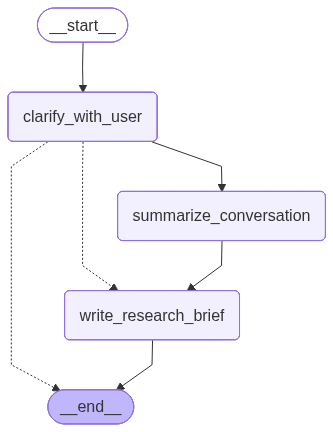

In [10]:
# ===== EXECUTION / DEMO =====
checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [14]:
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research about the best book available in India.")]}, config=thread)
format_messages(result['messages'])

✅ Research brief saved to outputs\research_brief_20250909_204515.md


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research about the best vegan protien source available in India.                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for providing the details. I will now research the best vegan protein sources available in India.     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine vegan food quality to assess the best vegan protein source in India.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for the clarification. I have sufficient information to proceed with researching the best vegan       │
│ protein sources in India, considering food quality. I will now begin the research.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research about the best book available in India.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what kind of book you are interested in? For example, are you looking for fiction,     │
│ non-fiction, a specific genre, or something else?                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [15]:
result = scope.invoke({"messages": [HumanMessage(content="Let's examine book content about spirituality and astronomical science in India.")]}, config=thread)
format_messages(result['messages'])

✅ Research brief saved to outputs\research_brief_20250909_204625.md
✅ Research brief saved to outputs\research_brief_20250909_204627.md


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research about the best vegan protien source available in India.                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for providing the details. I will now research the best vegan protein sources available in India.     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine vegan food quality to assess the best vegan protein source in India.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for the clarification. I have sufficient information to proceed with researching the best vegan       │
│ protein sources in India, considering food quality. I will now begin the research.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research about the best book available in India.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what kind of book you are interested in? For example, are you looking for fiction,     │
│ non-fiction, a specific genre, or something else?                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine book content about spirituality and astronomical science in India.                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for providing the details. I have sufficient information to proceed with researching the best books   │
│ on spirituality and astronomical science available in India. I will now begin the research.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [16]:
Markdown(result["research_brief"])

What are the highest-rated books on spirituality and astronomical science available in India, considering the      
content and quality of information presented?